Fitting a sine curve to a pceb light curve with astropy fitting. https://docs.astropy.org/en/stable/modeling/index.html

In [104]:
#usual bunch of imports

import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import lightkurve as lk
from matplotlib.gridspec import GridSpec



#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [105]:
from astropy.modeling import models, fitting


In [106]:
#grab a light curve and do all the normalisation etc. Using the PCEB CC Cet that I'm quite familar with.

search_result = lk.search_lightcurve('CC Cet')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 31,2020,SPOC,20,337219837,0.0
1,TESS Sector 31,2020,SPOC,120,337219837,0.0
2,TESS Sector 31,2020,TESS-SPOC,600,337219837,0.0


In [107]:
lc = search_result[0].download(download_dir='data/') #there is a 20s light curve, but I'll use the 2min one as it's the data you're familar with

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

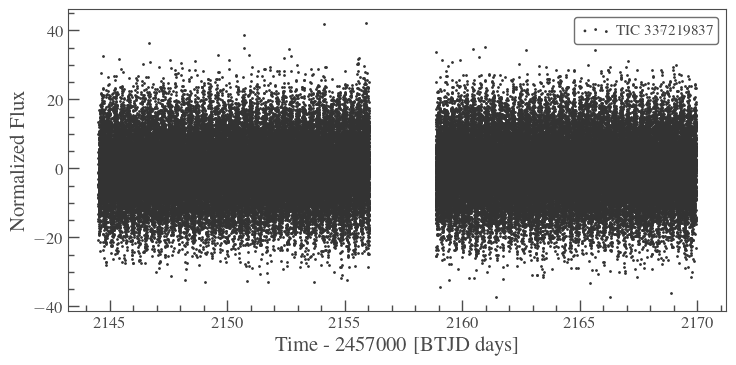

In [108]:
# lcn = lc.flatten(10001)
lcn = lc.normalize()
lcn.flux = lcn.flux.value -1
lcn.flux = lcn.flux*100
lcn.flux_err = lcn.flux_err.value*100
lcn=lcn.remove_nans()
lcn.scatter()

3.4612823715569814
0.2868948066810429 d


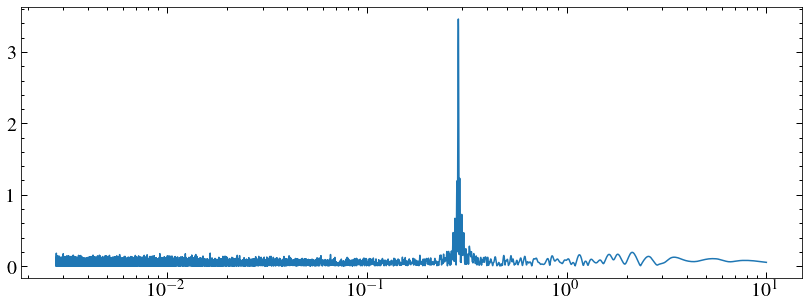

In [109]:
pg = lcn.to_periodogram(oversample_factor=10, minimum_period=4*u.min, maximum_period = 10*u.d)
plt.plot(pg.period, pg.power)
period = pg.period_at_max_power
print(pg.max_power)
print(pg.period_at_max_power)
plt.xscale('log')

Very easy period with no complicated extra harmonics. First we fit a sine curve to the whole light curve to get a precise peirod. Then we fold the light curve onto the period and fit for the amplitude and phase.

In [192]:
# -3.695494014784872
-2.6953779471917727  % 1


0.3046220528082273

Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude          frequency             phase       
    ------------------ ------------------ -------------------
    3.4673868756469517 3.4872207104203516 -2.6953779471917727
Amplitude = 3.4673868756469517 0.03864148115186748 %
Phase = -2.6953779471917727 0.4915404623478223


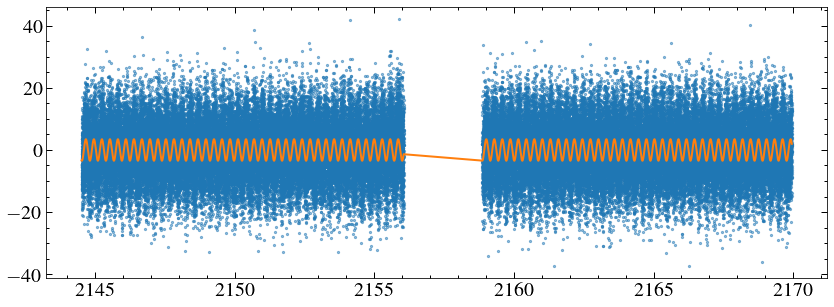

In [189]:
fitter = fitting.LevMarLSQFitter()

sin_mod =  models.Sine1D(amplitude=pg.max_power.value, frequency= pg.frequency_at_max_power.value, phase=0.5)#, bounds=dict(phase=[0,5]))
sin_fit = fitter(sin_mod, lcn.time.value, lcn.flux.value, weights = 1/lcn.flux_err.value, maxiter=100000)
print(sin_fit)
sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
plt.scatter(lcn.time.value, lcn.flux,s=5,alpha=0.5) 
plt.plot(lcn.time.value, sin_fit(lcn.time.value), c='C1', lw=2)
print('Amplitude =', sin_fit.amplitude.value, sin_fit_e[0], '%')
print('Phase =', sin_fit.phase.value, sin_fit_e[2])


Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude      frequency        phase       
    ------------------ --------- -------------------
    -3.467386942368609       1.0 0.21784558687152863
Period = 6.882271583293914 0.0004497300460932105 h
Amplitude = -3.467386942368609 0.03864127383827105 %
Phase = 0.21784558687152863 0.001777916055914352


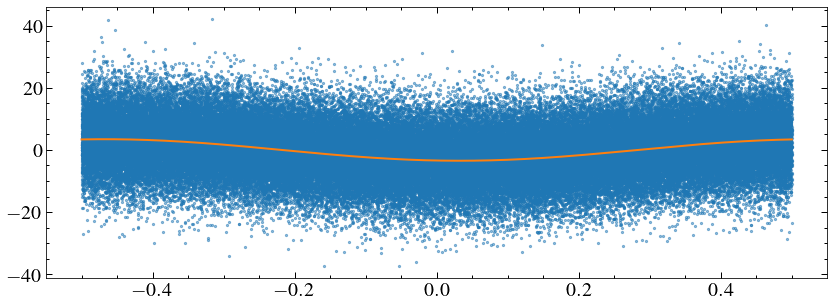

In [190]:
#now fold and refit


lcf = lcn.fold(1/sin_fit.frequency.value, normalize_phase=True)



sin_mod2 =  models.Sine1D(amplitude=sin_fit.amplitude.value, frequency= 1,phase= (sin_fit.phase.value % 1), fixed=dict(frequency=True)) #note frequency for the fit is now fixed
sin_fit2 = fitter(sin_mod2, lcf.time.value, lcf.flux.value, weights = 1/lcf.flux_err.value, maxiter=1000)
print(sin_fit2)
sin_fit_e2 = np.sqrt(np.diag(fitter.fit_info['param_cov']))
plt.scatter(lcf.time.value, lcf.flux,s=5,alpha=0.5) 
plt.plot(lcf.time.value, sin_fit2(lcf.time.value), c='C1', lw=2)
print('Period =', (1/sin_fit.frequency.value)*24, (sin_fit_e[1]/(sin_fit.frequency.value**2))*24, 'h')
print('Amplitude =', sin_fit2.amplitude.value, sin_fit_e2[0], '%')
print('Phase =', sin_fit2.phase.value, sin_fit_e2[1])



Referee wants a zoomed in version

(2145.0, 2146.0)

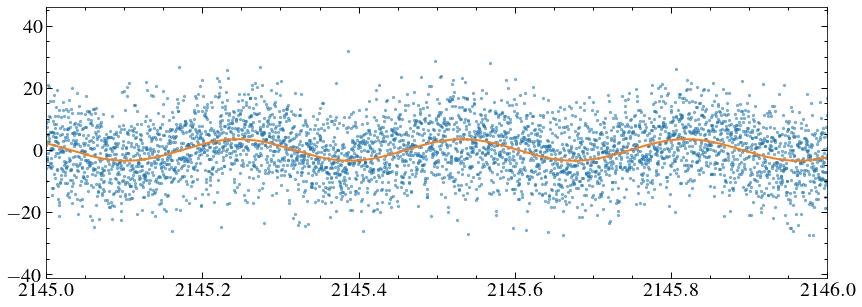

In [175]:
plt.scatter(lcn.time.value, lcn.flux,s=5,alpha=0.5) 
plt.plot(lcn.time.value, sin_fit(lcn.time.value), c='C1', lw=2)
plt.xlim(2145, 2146)

2144.7971579824366
2157.206604482028
2157.2352434461736
2157.5127839241927
2459157.512783924
0.0005098375478792224
2144.519617308289 2144.7971579824366


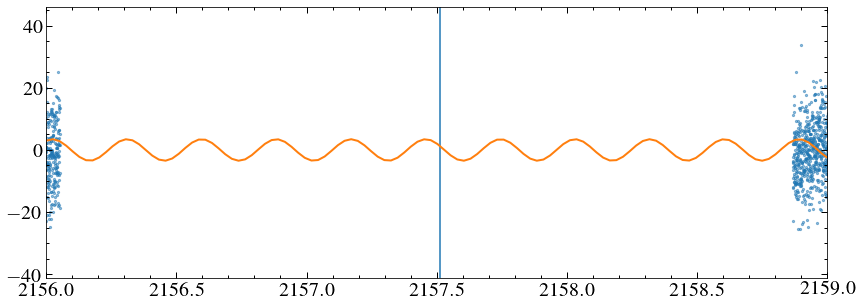

In [185]:
t0 = lcn.time[0].value + (1/sin_fit.frequency)*((sin_fit2.phase)+0.75) #0.5 = inferior conjunction
print(t0)
tmid = np.mean(lcn.time.value)
print(tmid)
tmid2 = lcn.time[0].value + (0.5 * (lcn.time[-1].value - lcn.time[0].value))
print(tmid2)
# eph = t0 + tmid2- lcn.time[0].value
# eph = tmid2 + (1/sin_fit.frequency)*(sin_fit2.phase)
# nhalf = (0.5 * (lcn.time[-1].value - lcn.time[0].value))*sin_fit.frequency.value #how many periods
# print(int(nhalf)/sin_fit.frequency.value)

# eph = t0 + int(nhalf)/sin_fit.frequency.value
print(eph)
# eph = 2157.16489

plt.xlim(2156, 2159)
plt.axvline(eph)
#plt.axvline(tmid)
# print(sin_fit.phase, sin_fit_e[2])
plt.scatter(lcn.time.value, lcn.flux,s=5,alpha=0.5) 
timefit = np.linspace(lcn.time[0].value, lcn.time[-1].value, 1000)

sin_fit3 =  models.Sine1D(amplitude=sin_fit2.amplitude.value, frequency= sin_fit.frequency.value, phase= sin_fit2.phase.value)
plt.plot(timefit, sin_fit3(timefit), c='C1', lw=2)

print(eph+2457000)
print(1/sin_fit.frequency.value*sin_fit_e2[1])

print(lcn.time[0], t0)

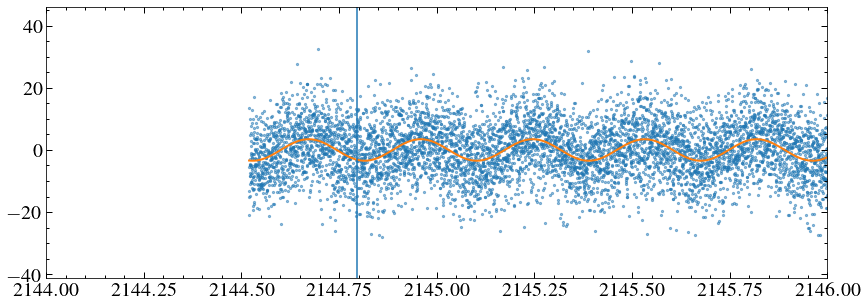

In [186]:
plt.scatter(lcn.time.value, lcn.flux,s=5,alpha=0.5) 
plt.plot(lcn.time.value, sin_fit(lcn.time.value), c='C1', lw=2)
plt.xlim(2144, 2146)
plt.axvline(t0)

In [114]:
fake_peaks = np.load('fake_peaks5.npy')
fa99 = np.percentile(fake_peaks, 99.9)
print(fa99)

0.24260854351745784


<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux'>

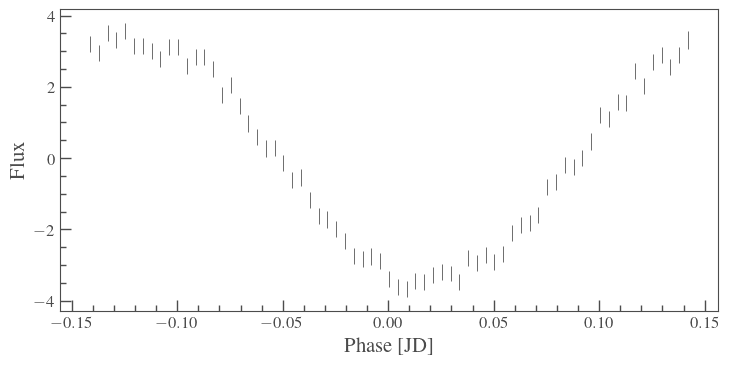

In [187]:
lcf = lcn.fold(1/sin_fit.frequency.value, epoch_time=t0).bin(0.1*u.hr)
lcf.errorbar()

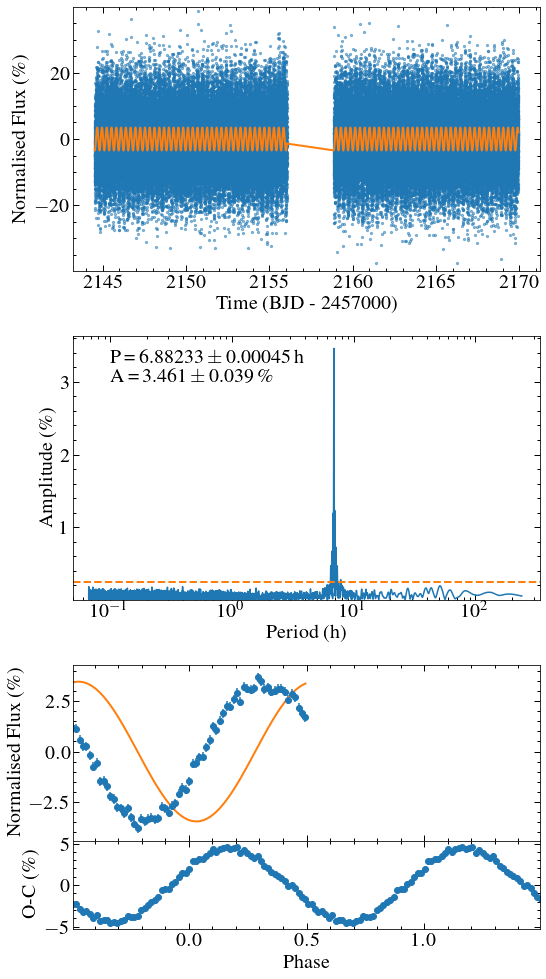

In [116]:
plt.figure(figsize=(8, 14))
gs = GridSpec(3, 1)
plt.subplot(gs[1, :])
pg20h = pg.period.to(u.hour)
plt.plot(pg20h, pg.power)
plt.xscale('log')
plt.axhline(fa99, c='C1', ls='--', lw=2)

plt.xlim(0.05, 14*24)#pg20h[0].value)
plt.ylim(0.0001)
plt.ylabel('Amplitude (\%)', size=20)
plt.xlabel('Period (h)', size=20)
#axins = inset_axes(ax, width='40%', height='30%', loc=2)
#axins.plot(pg1m[mask], pg1.power[mask])
plt.annotate('P\,=\,{0}\,$\pm$\,{1}\,h \n A\,=\,{2}\,$\pm$\,{3}\,\%'.format(6.88233,0.00045, 3.461,  0.039), (0.1, 3.), xycoords='data')
#6.882326693607637 0.0004561525821496103
#-3.4613593519684556 0.039138214912684814

# plt.annotate('0.1\% False Alarm Probability = 0.243\%', (0.95, fa99+0.1), xycoords=('axes fraction', 'data'), ha='right', va='bottom')

plt.subplot(gs[0, :])


plt.scatter(lcn.time.value, lcn.flux,s=5,alpha=0.5) 
plt.plot(lcn.time.value, sin_fit(lcn.time.value), c='C1', lw=2)




plt.ylabel('Normalised Flux (\%)', size=20)
plt.xlabel('Time (BJD - 2457000)', size=20)
plt.ylim(-39.9, 39.9)

gs1 = gs[2].subgridspec(3, 1, hspace=0)
plt.subplot(gs1[:2, :])
lcf = lcn.fold(1/sin_fit.frequency.value, epoch_time=eph).bin(0.1*u.hr)


# plt.scatter(lcf.time.value*sin_fit.frequency.value, lcf.flux,s=5,alpha=0.5) 
# plt.plot(lcf.time.value*sin_fit.frequency.value, sin_fit2(lcf.time.value), c='C1', lw=2)

# lcf_mod =  models.Sine1D(amplitude=fold_fit.amplitude, frequency= 1, phase=0, fixed={'amplitude': True, 'frequency':True})
# lcf_fit = fitter(lcf_mod, lcf.time, lcf.flux, weights = 1/lcf.flux_err, maxiter=100000)
#two cycles
plt.errorbar(lcf.time.value*sin_fit.frequency.value, lcf.flux, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
plt.plot(lcf.time.value*sin_fit.frequency.value, sin_fit2(lcf.time.value), c='C1', lw=2)
# plt.errorbar(lcf.time+1, lcf.flux, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
# plt.plot(fold_time+1, lcf_fit(fold_time), c='C1', lw=2, zorder=10)

plt.ylabel('Normalised Flux (\%)', size=20)
plt.xticks(visible=False)

xlims = [-0.49, 1.49] #storing here to update both plots at once
plt.xlim(xlims[0], xlims[1])

plt.subplot(gs1[2:, :])
mod = sin_fit2(lcf.time.value)
plt.errorbar(lcf.time.value*sin_fit.frequency.value, lcf.flux-mod, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
plt.errorbar(lcf.time.value*sin_fit.frequency.value+1, lcf.flux-mod, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
plt.xlim(xlims[0], xlims[1])
plt.ylabel('O-C (\%)', size=20)

plt.xlabel('Phase', size=20)
plt.tight_layout()
#plt.subplots_adjust(hspace=0.18)
# ax.subplots_adjust(hspace=0.7)
#ax1.set_top=0.99
#ax.set_bottom=0.01
# plt.savefig('plots/cc_cet_tess_20s.pdf', dpi=150)

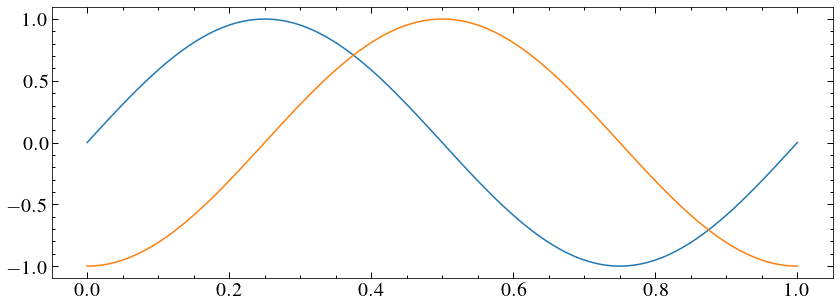

In [122]:
time = np.linspace(0, 1, 100)
sine = models.Sine1D(1, 1, 0)
plt.plot(time, sine(time))
time = np.linspace(0, 1, 100)
sine = models.Sine1D(1, 1, 0.75)
plt.plot(time, sine(time))